In [10]:
import torch
import transformers
import sys
import os
import matplotlib.pyplot as plt

sys.path.append("../..")

from utils import experiment_logger
from secalign_refactored import secalign, config

In [11]:
model_rel_path = "<MODEL_PATH_HERE>"

os.environ["CUDA_VISIBLE_DEVICES"] = str(0)

load_model = False
if load_model:
    model, tokenizer, frontend_delimiters, _ = secalign.load_lora_model(model_rel_path, load_model=load_model, device_map="cuda:0")

    inst_delm = config.DELIMITERS[frontend_delimiters][0]
    data_delm = config.DELIMITERS[frontend_delimiters][1]
    resp_delm = config.DELIMITERS[frontend_delimiters][2]

    prompt_template = config.PROMPT_FORMAT[frontend_delimiters]
    model = model.eval()
    model.generation_config.pad_token_id = tokenizer.pad_token_id
    model.generation_config.temperature = 0.0
    model.generation_config.do_sample=False
else:
    model, tokenizer, frontend_delimiters, _ = None, None, None, None

In [12]:
logger = experiment_logger.ExperimentLogger(".")

final_average_losses = []

for training_set_size, average_logprobs_list in enumerate(logger.query({"variable_name": "average_logprobs_list", "function_name": "altogether_adversarial_opt"})):
    final_average_losses += average_logprobs_list
    # plt.figure()
    # plt.plot(average_logprobs_list)
    # plt.title(f"Training Set Size: {2 * (training_set_size + 1)}")
    # plt.ylim((0, 40))
    # plt.show()
    # plt.close()
    # print(f"Minimum loss with {2 * (training_set_size + 1)}: {min(average_logprobs_list)}")


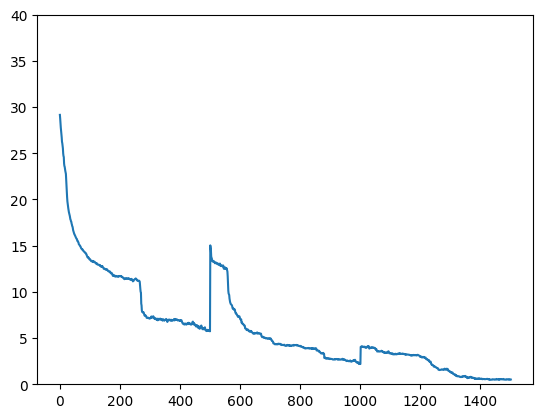

In [13]:
plt.figure()
plt.plot(final_average_losses)
plt.ylim((0, 40))
plt.show()
plt.close()

In [ ]:
list(logger.query({"variable_name": ""}))